In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning
from joblib import Parallel, delayed


In [2]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### SSM defintion

In [3]:
class ProposalMethod(ProposalMethodBase):
    def __init__(self, transition_matrix, covariance_matrix):
        locs = torch.zeros(covariance_matrix.shape[0], requires_grad=False)
        self.transition_matrix = transition_matrix
        self._dist = torch.distributions.MultivariateNormal(locs, covariance_matrix=covariance_matrix)
        
    def apply(self, state, _observation):
        x = (self.transition_matrix @ state.x.T).T
        sample = self._dist.rsample((x.shape[0],))
        return FilterState(x=sample, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix, observation_covariance_matrix):
        locs = torch.zeros(obs_matrix.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, 
                                                            covariance_matrix=observation_covariance_matrix)
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        
class NoResampling(BaseReweight):
    def apply(self, x, w, logw):
        return x, logw

In [4]:
_ = torch.random.manual_seed(0)

In [5]:
import math
import random
random.seed(42)

In [6]:
def ar_pf(values, 
          v11_tensor, v12_tensor, corr,
          observation_covariance_matrix,
          observation_matrix,
          transition_matrix,
          epsilon=0.5, 
          n=100, 
          seed=1234, 
          scaling=0.75, 
          reach=None, 
          min_neff=0.5, 
          resampling_method=None):
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_x = torch.zeros((n, observation_matrix.shape[1]))
    initial_x.requires_grad=False
    
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)

    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    
    torch_observation_matrix = torch.tensor(observation_matrix.astype(np.float32))
    torch_observation_covariance_matrix = torch.tensor(observation_covariance_matrix.astype(np.float32))
    likelihood_method = LikelihoodMethod(torch_observation_matrix, torch_observation_covariance_matrix)

    torch_noise_covariance_matrix = torch.zeros(transition_matrix.shape)
    
    torch_noise_covariance_matrix[0, 0] = v11_tensor
    torch_noise_covariance_matrix[0, 1] = rho * (v11_tensor * v12_tensor).sqrt()
    torch_noise_covariance_matrix[1, 0] = rho * (v11_tensor * v12_tensor).sqrt()
    torch_noise_covariance_matrix[1, 1] = v12_tensor
        
    torch_transition_matrix = torch.tensor(transition_matrix.astype(np.float32))
    proposal_method=ProposalMethod(torch_transition_matrix, torch_noise_covariance_matrix)
    
    if resampling_method is None:
        if epsilon > 0:
            resampling_method = Transport(epsilon=epsilon, scaling=scaling, reach=reach)
        else:
            resampling_method = SystematicResampling()
            
    boot = BootstrapFilter(proposal_method,
                           likelihood_method=likelihood_method, 
                           reweighting_method=resampling_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in values:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

In [178]:
transition_matrix

array([[0.5, 0. ],
       [0. , 0.5]])

In [7]:
def autoregressive(transition_matrix, observation_matrix, noise_covariance, observation_covariance, seed=42):
    np.random.seed(seed)
    x = np.zeros(transition_matrix.shape[1])
    sub_noise = np.linalg.cholesky(noise_covariance)
    sub_observation = np.linalg.cholesky(observation_covariance)
    yield (observation_matrix @ x + sub_observation @ np.random.randn(observation_matrix.shape[0])).squeeze()
    while True:
        x = (transition_matrix @ x + sub_noise @ np.random.randn(x.shape[0])).squeeze()
        yield (observation_matrix @ x + sub_observation @ np.random.randn(observation_matrix.shape[0])).squeeze()
    

In [8]:
np.random.randn()

-0.3433971612126028

In [9]:
v_11 = v_12 = 1.
v_21 = v_22 = 0.5
rho = 0.8
phi = 0.5

observation_matrix = np.eye(2)
noise_cov = np.array([[v_11, rho * math.sqrt(v_11 * v_12)], [rho * math.sqrt(v_11 * v_12), v_12]])
observation_cov = np.array([[v_21, 0.], [0., v_22]])
transition_matrix = np.eye(2) * phi

In [10]:
transition_matrix

array([[0.5, 0. ],
       [0. , 0.5]])

In [11]:
linspace = np.linspace(0., 1.5, 150)
n_experiments = 1


In [12]:
T = 200
observations_lists = []
for i in range(1):
    autoregressive_gen = autoregressive(transition_matrix, observation_matrix, noise_cov, observation_cov, seed=58+i)
    ar = [next(autoregressive_gen) for _ in range(T)]
    observations_lists.append(np.asanyarray(ar[:]).astype(np.float32))


[[1.  0. ]
 [0.8 0.6]]


In [14]:
data = observations_lists[0]

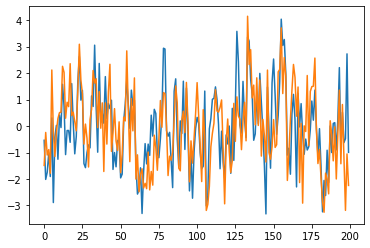

In [15]:
plt.plot(data)

In [16]:
N = 50
M = 50

In [17]:
linspace = np.linspace(0.5, 1.5, M)

In [18]:
v11s, v12s = np.meshgrid(linspace, linspace)

In [19]:
sys_ll = np.empty((M, M))
sys_grads_11 = np.empty((M, M))
sys_grads_12 = np.empty((M, M))
for i in tqdm.trange(M):
    for j in range(M):
        v11_tensor = torch.tensor(v11s[i, j], requires_grad=True)
        v12_tensor = torch.tensor(v12s[i, j], requires_grad=True)
        res = ar_pf(data, 
                    v11_tensor, v12_tensor, rho,
                      observation_cov,
                      observation_matrix,
                      transition_matrix, 0., n=N, min_neff=0.5, seed=12345)
        grad = torch.autograd.grad(-res[0] * T, [v11_tensor, v12_tensor])
        sys_ll[i, j] = -res[0].detach().cpu().numpy().sum()*T
        sys_grads_11[i, j] = grad[0].detach().cpu().numpy().sum()        
        sys_grads_12[i, j] = grad[1].detach().cpu().numpy().sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:59<00:00, 13.11s/it]


In [20]:
kf_ll_arr = np.empty((M, M))
kf_grads_11_arr = np.empty((M, M))
kf_grads_12_arr = np.empty((M, M))
for i in tqdm.trange(M):
    for j in range(M):
        v11_val = v11s[i, j]
        v12_val = v12s[i, j]
        
        v11_val_eps = v11_val + 1e-4
        v12_val_eps = v12_val + 1e-4
        
        transition_covariance = np.array([[v11_val, rho * math.sqrt(v11_val * v12_val)], [rho * math.sqrt(v11_val * v12_val), v12_val]])
        transition_covariance_11 = np.array([[v11_val_eps, rho * math.sqrt(v11_val_eps * v12_val)], [rho * math.sqrt(v11_val_eps * v12_val), v12_val]])
        transition_covariance_12 = np.array([[v11_val, rho * math.sqrt(v11_val * v12_val_eps)], [rho * math.sqrt(v11_val * v12_val_eps), v12_val_eps]])

        
        kf = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                                   transition_covariance=transition_covariance, 
                                   transition_matrices=transition_matrix, 
                                   observation_matrices=observation_matrix,
                                   initial_state_mean=[0., 0.],
                                   initial_state_covariance=np.diag([0., 0.]))
        kf_eps_11 = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                                          transition_covariance=transition_covariance_11, 
                                          transition_matrices=transition_matrix, 
                                          observation_matrices=observation_matrix,
                                          initial_state_mean=[0., 0.],
                                          initial_state_covariance=np.diag([0., 0.]))
        kf_eps_12 = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                                          transition_covariance=transition_covariance_12, 
                                          transition_matrices=transition_matrix,
                                          observation_matrices=observation_matrix,
                                          initial_state_mean=[0., 0.],
                                          initial_state_covariance=np.diag([0., 0.]))
        
        kf_ll = kf.loglikelihood(data)
        kf_ll_11 = kf_eps_11.loglikelihood(data)
        kf_ll_12 = kf_eps_12.loglikelihood(data)
        
        
        kf_ll_arr[i, j] = kf_ll
        kf_grads_11_arr[i, j] = (kf_ll_11-kf_ll)*1e4
        kf_grads_12_arr[i, j] = (kf_ll_12-kf_ll)*1e4

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:10<00:00, 30.24s/it]


In [22]:
reg_ll = np.empty((M, M))
reg_grads_11 = np.empty((M, M))
reg_grads_12 = np.empty((M, M))
for i in tqdm.trange(M):
    for j in range(M):
        v11_tensor = torch.tensor(v11s[i, j], requires_grad=True)
        v12_tensor = torch.tensor(v12s[i, j], requires_grad=True)
        res = ar_pf(data, 
                    v11_tensor, v12_tensor, rho,
                    observation_cov,
                    observation_matrix,
                    transition_matrix, 
                    0.25, 
                    n=N, 
                    min_neff=0.5, 
                    seed=12345)
        grad = torch.autograd.grad(-res[0] * T, [v11_tensor, v12_tensor])
        reg_ll[i, j] = -res[0].detach().cpu().numpy().sum()*T
        reg_grads_11[i, j] = grad[0].detach().cpu().numpy().sum()        
        reg_grads_12[i, j] = grad[1].detach().cpu().numpy().sum()

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:01:41<00:00, 62.25s/it]


In [23]:
learned_ll = np.empty((M, M))
learned_grads_11 = np.empty((M, M))
learned_grads_12 = np.empty((M, M))
for i in tqdm.trange(M):
    for j in range(M):
        v11_tensor = torch.tensor(v11s[i, j], requires_grad=True)
        v12_tensor = torch.tensor(v12s[i, j], requires_grad=True)
        learnt_resampling_method = LearnBest(0.1, {'scaling': 0.33}, learning_rate=1., optimizer_kwargs={}, 
                                             schedule_kwargs={'gamma': 0.9, 'step_size':1}, n_steps=5, 
                                             start_from_regularised=True,
                                             jitter=0., 
                                             optim_class_name='SGD',
                                             scheduler_class_name='StepLR')
        res = ar_pf(data, 
                    v11_tensor, v12_tensor, rho,
                    observation_cov,
                    observation_matrix,
                    transition_matrix, 
                    0.25, 
                    n=N, 
                    min_neff=0.5, 
                    seed=12345)
        grad = torch.autograd.grad(-res[0] * T, [v11_tensor, v12_tensor])
        learned_ll[i, j] = -res[0].detach().cpu().numpy().sum()*T
        learned_grads_11[i, j] = grad[0].detach().cpu().numpy().sum()        
        learned_grads_12[i, j] = grad[1].detach().cpu().numpy().sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [48:49<00:00, 61.85s/it]


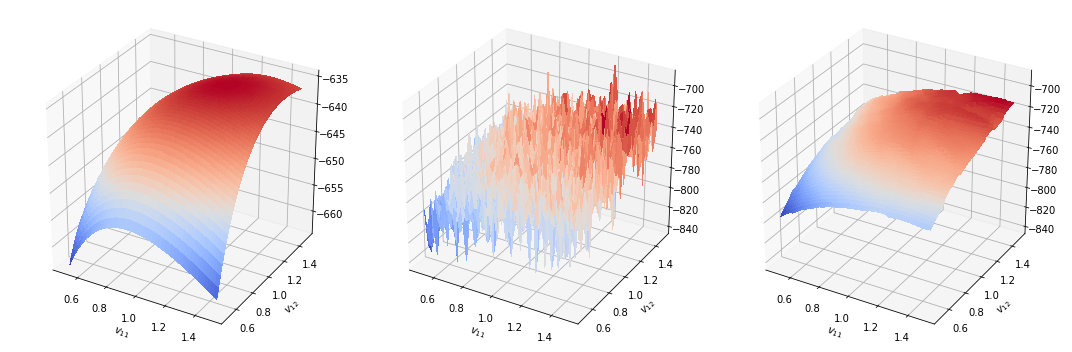

In [195]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm


fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_xlabel('$v_{11}$')
ax1.set_ylabel('$v_{12}$')
ax1.plot_surface(v11s, v12s, kf_ll_arr, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_xlabel('$v_{11}$')
ax2.set_ylabel('$v_{12}$')
ax2.plot_surface(v11s, v12s, sys_ll, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_xlabel('$v_{11}$')
ax3.set_ylabel('$v_{12}$')
ax3.plot_surface(v11s, v12s, reg_ll, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.tight_layout()
fig.savefig('likelihood2D.png')

zlim_inf = float('inf')
zlim_sup = -float('inf')
for ax in [ax2, ax3]:
    zlim_sub, zlim_up = ax.get_zlim()
    zlim_inf = min(zlim_inf, zlim_sub)
    zlim_sup = max(zlim_sup, zlim_up)
    
for ax in [ax2, ax3]:
    ax.set_zlim(zlim_inf, zlim_sup)


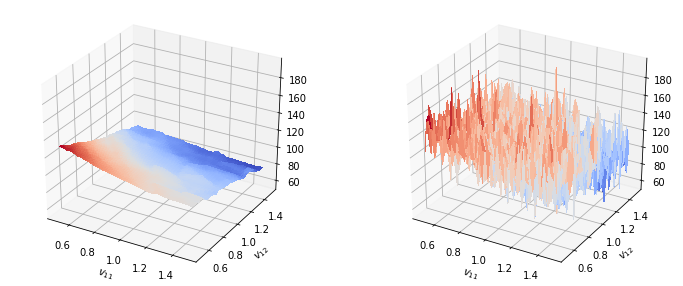

In [190]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel('$v_{11}$')
ax1.set_ylabel('$v_{12}$')
ax1.plot_surface(v11s, v12s, kf_ll_arr - reg_ll, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('$v_{11}$')
ax2.set_ylabel('$v_{12}$')
ax2.plot_surface(v11s, v12s, kf_ll_arr - sys_ll, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

zlim_inf = float('inf')
zlim_sup = -float('inf')
for ax in [ax1, ax2]:
    zlim_sub, zlim_up = ax.get_zlim()
    zlim_inf = min(zlim_inf, zlim_sub)
    zlim_sup = max(zlim_sup, zlim_up)
    
for ax in [ax1, ax2]:
    ax.set_zlim(zlim_inf, zlim_sup)

fig.savefig('bias2D.png')

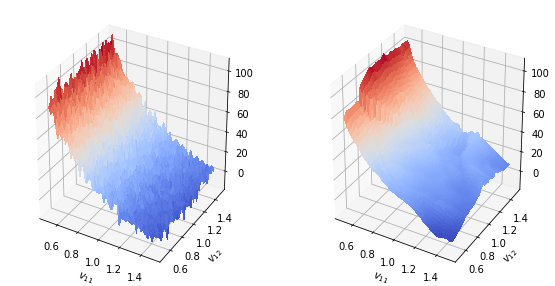

In [97]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm


fig = plt.figure(figsize=(15, 5))



ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_xlabel('$v_{11}$')
ax2.set_ylabel('$v_{12}$')
ax2.plot_surface(v11s, v12s, sys_grads_11, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_xlabel('$v_{11}$')
ax3.set_ylabel('$v_{12}$')
ax3.plot_surface(v11s, v12s, reg_grads_11, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.savefig('gradient2D.png')

zlim_inf = float('inf')
zlim_sup = -float('inf')
for ax in [ax2, ax3]:
    zlim_sub, zlim_up = ax.get_zlim()
    zlim_inf = min(zlim_inf, zlim_sub)
    zlim_sup = max(zlim_sup, zlim_up)
    
for ax in [ax2, ax3]:
    ax.set_zlim(zlim_inf, zlim_sup)
#     ax.view_init(30, 20)



In [155]:
n_iter = 150
lr = .5
v11_tensor = torch.tensor(1., requires_grad=True)
v12_tensor = torch.tensor(1., requires_grad=True)
v11_values_sys = [1.]
v12_values_sys = [1.]
ll_sys_list = []

for _ in range(n_iter):
    
    
    temp_res = res = ar_pf(data, 
                           v11_tensor, v12_tensor, rho,
                           observation_cov,
                           observation_matrix,
                           transition_matrix, 
                           0., 
                           n=25, 
                           min_neff=0.5, 
                           seed=666)
    
    grad = torch.autograd.grad(temp_res[0], [v11_tensor, v12_tensor])
    
    ll_sys_list.append(temp_res[0].detach().cpu().numpy().sum())
    
    v11_tensor.data -= lr * grad[0]
    v12_tensor.data -= lr * grad[1]
    v11_values_sys.append(v11_tensor.detach().cpu().numpy().sum())
    v12_values_sys.append(v12_tensor.detach().cpu().numpy().sum())


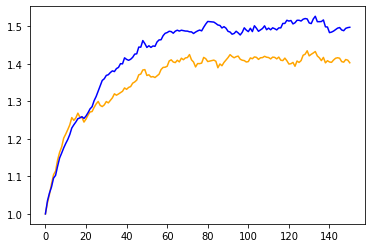

In [182]:
plt.plot(v11_values_sys, color='orange')
plt.plot(v12_values_sys, color='blue')

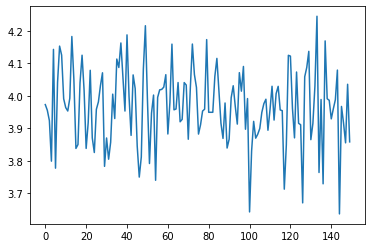

In [157]:
plt.plot(np.roll ll_sys_list)

In [187]:
n_iter = 100
lr = 0.25
v11_tensor = torch.tensor(1., requires_grad=True)
v12_tensor = torch.tensor(1., requires_grad=True)
v11_values_reg = [1.]
v12_values_reg = [1.]
ll_reg_list = []
grads_reg_list = []

for _ in range(n_iter):
    temp_res = res = ar_pf(data, 
                           v11_tensor, v12_tensor, rho,
                           observation_cov,
                           observation_matrix,
                           transition_matrix, 
                           0.25, 
                           scaling=0.5,
                           n=25, 
                           min_neff=0.5, 
                           seed=666)
    ll_reg_list.append(temp_res[0].detach().cpu().numpy().sum())
    grad = torch.autograd.grad(temp_res[0], [v11_tensor, v12_tensor])
    grads_reg_list.append([k.detach().cpu().numpy().sum()for k in grad])
    v11_tensor.data -= lr * grad[0]
    v12_tensor.data -= lr * grad[1]
    v11_values_reg.append(v11_tensor.detach().cpu().numpy().sum())
    v12_values_reg.append(v12_tensor.detach().cpu().numpy().sum())
    

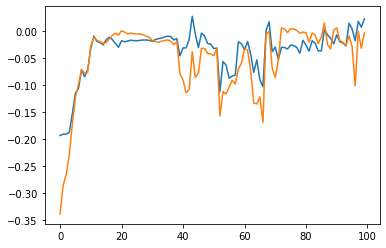

In [189]:
plt.plot(grads_reg_list)

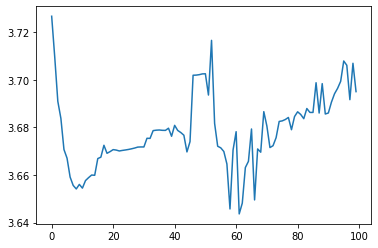

In [188]:
plt.plot(ll_reg_list)

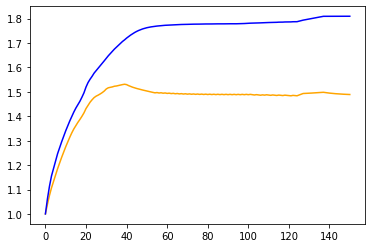

In [186]:
plt.plot(v11_values_reg, color='orange')
plt.plot(v12_values_reg, color='blue')

In [83]:
kf.em(data, em_vars=['transition_covariance'], n_iter=150)

In [181]:
n_iter = 100
lr = 0.5
v11_val = 1.
v12_val = 1.
v11_values_kf = [1.]
v12_values_kf = [1.]
ll_kf_list = []

for _ in range(n_iter):
        
    v11_val_eps = v11_val + 1e-4
    v12_val_eps = v12_val + 1e-4
    transition_covariance = np.array([[v11_val, rho * math.sqrt(v11_val * v12_val)], [rho * math.sqrt(v11_val * v12_val), v12_val]])
    transition_covariance_11 = np.array([[v11_val_eps, rho * math.sqrt(v11_val_eps * v12_val)], [rho * math.sqrt(v11_val_eps * v12_val), v12_val]])
    transition_covariance_12 = np.array([[v11_val, rho * math.sqrt(v11_val * v12_val_eps)], [rho * math.sqrt(v11_val * v12_val_eps), v12_val_eps]])


    kf = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                               transition_covariance=transition_covariance, 
                               transition_matrices=transition_matrix, 
                               observation_matrices=observation_matrix,
                               initial_state_mean=[0., 0.],
                               initial_state_covariance=np.diag([0., 0.]))
    kf_eps_11 = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                                      transition_covariance=transition_covariance_11, 
                                      transition_matrices=transition_matrix, 
                                      observation_matrices=observation_matrix,
                                      initial_state_mean=[0., 0.],
                                      initial_state_covariance=np.diag([0., 0.]))
    kf_eps_12 = pykalman.KalmanFilter(observation_covariance=observation_cov, 
                                      transition_covariance=transition_covariance_12, 
                                      transition_matrices=transition_matrix,
                                      observation_matrices=observation_matrix,
                                      initial_state_mean=[0., 0.],
                                      initial_state_covariance=np.diag([0., 0.]))

    kf_ll = -kf.loglikelihood(data) / T
    kf_ll_11 = -kf_eps_11.loglikelihood(data) /T
    kf_ll_12 = -kf_eps_12.loglikelihood(data)/T

    ll_kf_list.append(kf_ll)
    grad1 = (kf_ll_11-kf_ll)*1e4
    grad2 = (kf_ll_12-kf_ll)*1e4
    
    v11_val -= lr * grad1
    v12_val -= lr * grad2
    v11_values_kf.append(v11_val)
    v12_values_kf.append(v12_val)


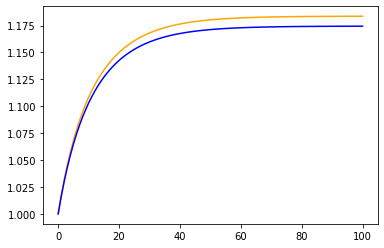

In [183]:
plt.plot(v11_values_kf, color='orange')
plt.plot(v12_values_kf, color='blue')